## This Notebook outlines the loading and minimal examination of precipitation data from:
## 1. May Creek SNOTEL site
## 2. Gates Glacier IRMA site
## 3. Chinese AWS

### Note that this notebook is mostly for visual purposes, as the raw data files are not stored on GitHub and thus this script can not be run in a browser.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,csv
# plotting
pd.plotting.register_matplotlib_converters()
plt.style.use('ggplot')

raw_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\Raw_Climate_Records'
format_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\DATA'

### 1. Load SNOTEL Data from May Creek Station

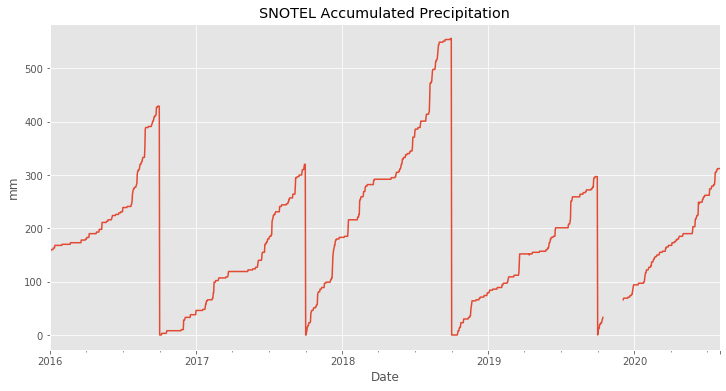

In [2]:
# ---- SNOTEL - Daily (Start of day) values 
snotel_path = os.path.join(raw_data,'SNOTEL_1096_MayCreek.txt')
# read in with pandas
snotel = pd.read_csv(snotel_path,header=56,parse_dates=True,index_col='Date')
# rename cols, units= mm, mm, cm, mm
# columns are accumulated precip per water year, precipitation increment, snow depth, snow water equivalent
snotel.columns = ['Precip_acc','Precip_inc','SDS','SWES'] 
# remove suspect data
snotel['SDS'] = snotel['SDS'].where(snotel.SDS < 100) # remove anamalously high snow depth value 

# Plot up accumulated precip record
fig,ax = plt.subplots(figsize=(12,6))
snotel.Precip_acc.plot(ax=ax)
ax.set_ylabel('mm')
ax.set_title('SNOTEL Accumulated Precipitation')
plt.show()

### 2. Gates Glacier AWS 

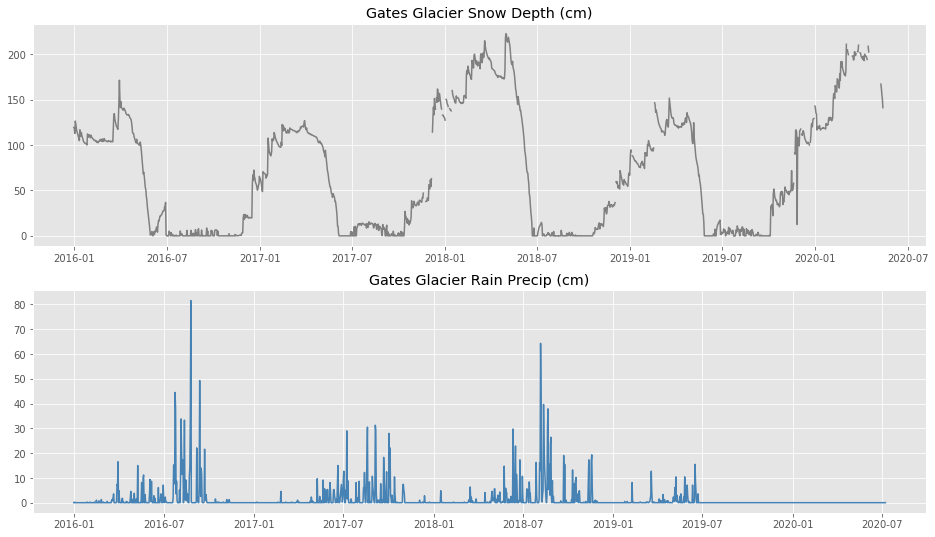

In [3]:
# NPS IRMA gates QAQC-ed data through 2019
gates_path = os.path.join(raw_data,'WC_G_GGLA2.csv')
# read with pandas
gates_full = pd.read_csv(gates_path,skip_blank_lines=False,header=14,
                    parse_dates=['timestamp_utc'],index_col=['timestamp_utc'])
# subset out precip columns
gates_full.index = gates_full.index.tz_localize('utc').tz_convert('US/Alaska').rename('DATE')
start = pd.Timestamp('2016-01-01 00:00:00-0800',tz='US/Alaska')
end = gates_full.index[-1]
gates_irma = gates_full.loc[slice(start,end),['sdi','rnin']]
gates_irma.columns = ['SD','RN'] # rename columns to match

# load csv of ~last year data from Gates Gl (not finalized)
# accessed via https://download.synopticdata.com/#a/GGLA2
gates2019_path = os.path.join(raw_data,'GGLA2.2020-07-07.csv')
# read in
gates2019 = pd.read_csv(gates2019_path, header=10, skiprows=[11],
                        parse_dates=['Date_Time'],index_col=['Date_Time'])
# convert time to AK then coerce to hourly timestamps
gates2019.index = (gates2019.index - pd.Timedelta(33,'minutes')).tz_convert('US/ALASKA').rename('DATE') 
# subset for concatenation
start2 = end + pd.Timedelta(1,'hour') # don't duplicate values from the QC-ed data in gates_sub
gates2019_sub = pd.DataFrame(gates2019.loc[start2:,'snow_depth_set_1'])
gates2019_sub.columns = ['SD'] # rename for concat

# --- Concatenate dataframes to combine record
gates_precip = pd.concat([gates_irma,gates2019_sub]) 
# remove bad values over 100
gates_precip['SD'] = gates_precip['SD'].where(gates_precip['SD'] < 100)

# convert values to metric
gates_precip = gates_precip * 2.54 # convert inches to cm
gates_precip['RN'] = gates_precip.loc[:,'RN'] * 10 # cm to mm

# resample to daily: mean for hourly SD and sum for hourly rain accum.
gatesdd_precip = gates_precip.resample('D').agg({'SD':'first','RN':'sum'})


#---- plot time series
pd.plotting.register_matplotlib_converters() # for some reason this needs to be run again
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(16,9))
#  plot snow
ax1.plot(gatesdd_precip.index,gatesdd_precip.SD,color='gray')
ax1.set_title('Gates Glacier Snow Depth (cm)')
# plot rain
ax2.plot(gatesdd_precip.index,gatesdd_precip.RN,color='steelblue')
ax2.set_title('Gates Glacier Rain Precip (cm)')

plt.show()

### 3. Chinese AWS

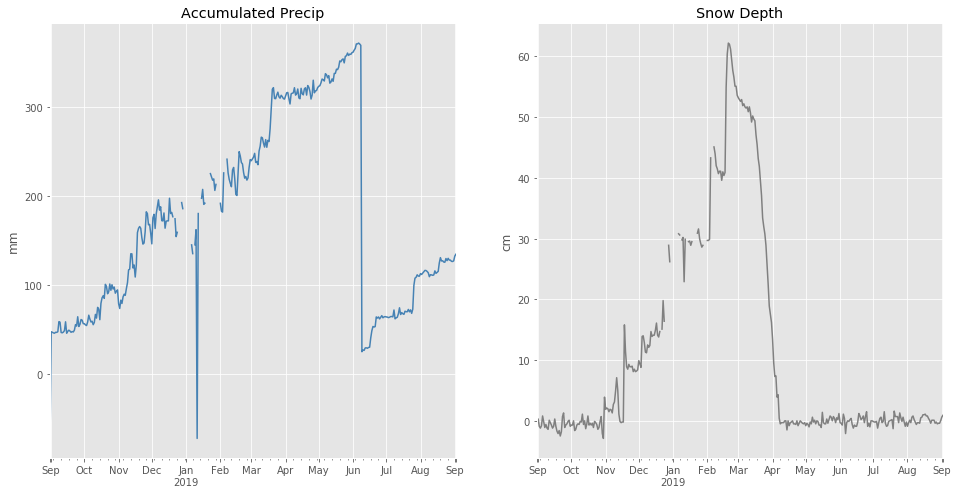

In [4]:
# ---- Chinese AWS lower on Kennicott ~675 m and off-glacier. Upper is 2185 m but fell down..
# get paths
dat_files = [f for f in os.listdir(raw_data) if f.endswith('.dat')]
lowerpath = os.path.join(raw_data,dat_files[0])
upperpath = os.path.join(raw_data,dat_files[1])
# read in lower chinese station
caws_raw = pd.read_csv(lowerpath,header=0,skiprows=[0,2,3],parse_dates=True,
                    index_col='TIMESTAMP')
# read in metadata header to get units of precip cols
with open(lowerpath,newline='') as f:
    head = [next(f) for x in range(4)]
# look up units for 'RainSnow'
names = head[1].split(',')
units = head[2].split(',')
rsun = units[names.index('"RainSnow"')] # units are mm
    
# explore
caws_raw = caws_raw.astype(dtype={'Snow_depth_Avg':float})
# resample to daily to match other precip records
caws = caws_raw.resample('D').agg({'Snow_depth_Avg':'first','RainSnow':'first'})  
caws = caws.loc[:,['Snow_depth_Avg','RainSnow']] # just get precip
caws.columns = ['SD','RS'] # rename
# coerce closer to actual values
corr = 176.4 # cm; correction height for snow depth sensor
caws['SD'] = caws['SD'] + corr # try to get non-snow values back near 0
# make new precip increment columns
caws['Precip_inc'] = caws.RS.diff() # find row differences
caws.Precip_inc.loc[caws.Precip_inc < 0] = np.nan

# visualize snow and precip records
fig,[ax1,ax2]= plt.subplots(1,2,figsize=(16,8))
caws.RS.plot(ax=ax1,title='Accumulated Precip',color='steelblue')
ax1.set_ylabel('mm'),ax1.set_xlabel('')
caws.SD.plot(ax=ax2,title='Snow Depth',color='gray')
ax2.set_ylabel('cm'),ax2.set_xlabel('')
plt.show()

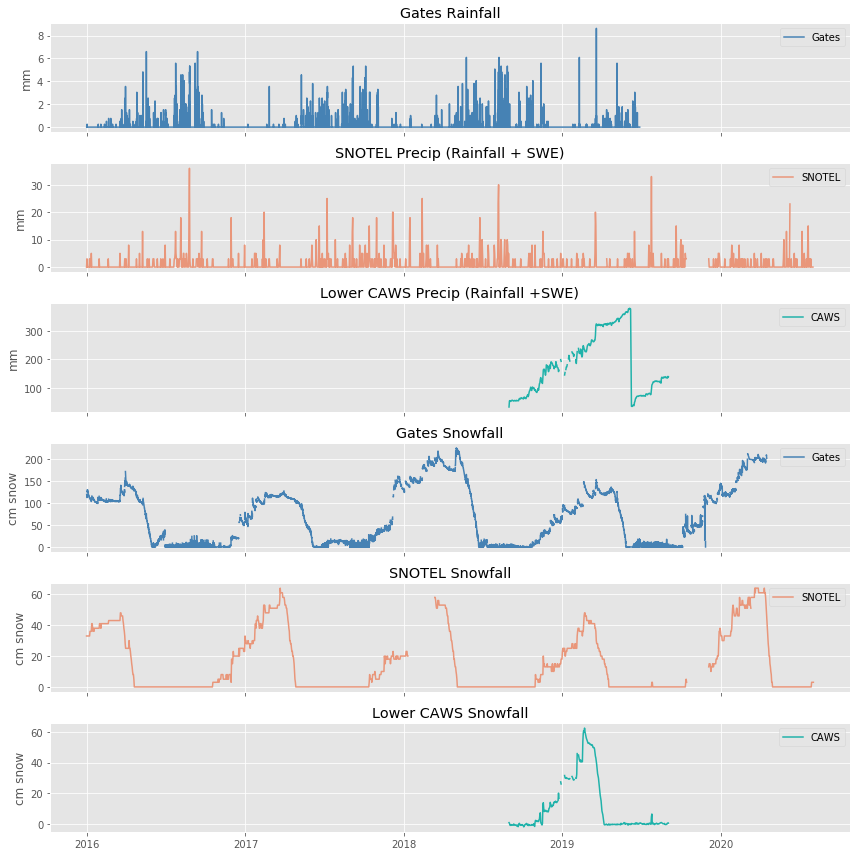

In [5]:
# ---- Plot suitable precip data (non-snow) on one plot
# gates and SNOTEL
fig,[ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(6,1,sharex=True,figsize=(12,12))
pd.plotting.register_matplotlib_converters() # for some reason this needs to be run again
g,s,c = 'steelblue','darksalmon','lightseagreen'
# precip plots
ax1.set_title('Gates Rainfall')
ax1.plot(gates_precip.index,gates_precip.RN,label='Gates',color=g)
ax1.set_ylabel('mm')
ax1.legend()
ax2.set_title('SNOTEL Precip (Rainfall + SWE)')
ax2.plot(snotel.index,snotel.Precip_inc,label='SNOTEL',color=s)
ax2.set_ylabel('mm')
ax2.legend()
ax3.set_title('Lower CAWS Precip (Rainfall +SWE)')
ax3.plot(caws.index,caws.RS,label='CAWS',color=c)
ax3.set_ylabel('mm')
ax3.legend()

# snowfall
ax4.set_title('Gates Snowfall')
ax4.plot(gates_precip.index,gates_precip.SD,label='Gates',color=g)
ax4.set_ylabel('cm snow')
ax4.legend()
ax5.set_title('SNOTEL Snowfall')
ax5.plot(snotel.index,snotel.SDS,label='SNOTEL',color=s)
ax5.set_ylabel('cm snow')
ax5.legend()
ax6.set_title('Lower CAWS Snowfall')
ax6.plot(caws.index,caws.SD,label='CAWS',color=c)
ax6.set_ylabel('cm snow')
ax6.legend()

fig.tight_layout()
plt.show()


## To view the below figure without the scroll bar, click in the white space anywhere immediately to the left of the figure.
## The figure should then expand to its own cell.

## The three precipitation records above can now be saved to the github and accessed in the browser below for further visualization

### 1. Pickle (save) each station individually 

In [6]:
# set pickle paths
snotel_path = os.path.join(format_data,'snotel_precip.pickle')
gates_path = os.path.join(format_data,'gates_precip.pickle')
caws_path = os.path.join(format_data,'lower_caws_precip.pickle')

In [7]:
# save variable dataframes
snotel.to_pickle(snotel_path)
gatesdd_precip.to_pickle(gates_path)
caws.to_pickle(caws_path)

In [ ]:
# save to csv
snotel.to_csv(os.path.join(format_data,'snotel_precip.csv'))
gatesdd_precip.to_csv(os.path.join(format_data,'gates_precip.csv'))
caws.to_csv(os.path.join(format_data,'lower_caws_precip.csv'))

### 2. Now open precipitation records in browser using pandas read_pickle

#### - Run cells 1, 6, and 9 to load dataframes. Code in other cells can be skipped over.

In [14]:
# open precipitation dataframes
snotel = pd.read_pickle(snotel_path)
gates = pd.read_pickle(gates_path)
caws = pd.read_pickle(caws_path)

# view columns (Ex)
#gates.columns

# view first 6 lines to verify index increment and column headers
gates.head()

,SD,RN
DATE,,
2015-12-31 00:00:00-09:00,119.380,0.000
2016-01-01 00:00:00-09:00,118.872,0.000
2016-01-02 00:00:00-09:00,112.776,0.254
2016-01-03 00:00:00-09:00,126.492,0.000
2016-01-04 00:00:00-09:00,123.190,0.000
